## 3. Train
Experiment with different models to find best results

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime
import pickle

In [2]:
data = pd.read_csv('marketing_campaign.csv', sep=';')

### Train-test Split, Preprocessing, Feature Generation

In [3]:
# Create train test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
class FeatureEngineering:
    def __init__(self, data, preprocessing_type='test'):
        self.data = data
        self.median_income = None
        self.income_cutoff = None
        self.preprocessing_type = preprocessing_type

    def preprocessing(self):
        # Calculate Age and remove outliers
        self.data['Age'] = datetime.datetime.now().year - self.data['Year_Birth'] 
        self.data = self.data[self.data['Age'] < 100]

        # Calculate Tenure
        self.data['Dt_Customer'] = pd.to_datetime(self.data['Dt_Customer'])
        self.data['Tenure'] = datetime.datetime.now().year - self.data['Dt_Customer'].dt.year

        # Create Total Children
        self.data['Total_Children'] = self.data['Kidhome'] + self.data['Teenhome']

        # Fix Marital Status
        self.data['Marital_Status'] = self.data['Marital_Status'].replace(['YOLO', 'Alone', 'Absurd'], 'Single')

        # Remove outlier and impute median income
        if self.preprocessing_type == 'train':
            Q3 = np.quantile(data['Income'].dropna(), 0.75)
            Q1 = np.quantile(data['Income'].dropna(), 0.25)
            IQR = Q3 - Q1
            self.income_cutoff = Q3 + 1.5 * IQR
            self.median_income = self.data.loc[self.data['Income'] < self.income_cutoff, 'Income'].median()

        self.data.loc[self.data['Income'] > self.income_cutoff, 'Income'] = self.median_income
        self.data['Income'] = self.data['Income'].fillna(self.median_income)

        # Set ID as index
        self.data = self.data.set_index('ID')

        # Drop columns
        self.data = self.data.drop(['Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue'], axis=1)
    
    def get_data(self) -> pd.DataFrame:
        return(self.data)

In [5]:
processing_train = FeatureEngineering(train, preprocessing_type='train')
processing_train.preprocessing()
preprocessed_Xtrain = processing_train.get_data()

In [6]:
preprocessing_test = FeatureEngineering(test, preprocessing_type='test')
preprocessing_test.median_income = processing_train.median_income
preprocessing_test.income_cutoff = processing_train.income_cutoff
preprocessing_test.preprocessing()
preprocessed_Xtest = preprocessing_test.get_data()

### Train Experimentation

In [7]:
from pycaret.classification import *

In [8]:
s = setup(preprocessed_Xtrain, 
          target = 'Response',
          preprocess = True,
          session_id=123)

,Description,Value
0,Session id,123
1,Target,Response
2,Target type,Binary
3,Original data shape,"(1791, 27)"
4,Transformed data shape,"(1791, 35)"
5,Transformed train set shape,"(1253, 35)"
6,Transformed test set shape,"(538, 35)"
7,Numeric features,24
8,Categorical features,2
9,Preprocess,True


In [10]:
## lightgbm has the greatest AUC
## Assumption: there's limited budget to send out marketing campaigns so we want to decrease the amount sent to customers
## -> optimise recall

compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8938,0.8800,0.5450,0.6775,0.5998,0.5399,0.5465,0.0930
gbc,Gradient Boosting Classifier,0.8922,0.8956,0.4538,0.7204,0.5542,0.4965,0.5151,0.1770
lda,Linear Discriminant Analysis,0.8898,0.8917,0.5289,0.6493,0.5797,0.5180,0.5230,0.0330
ridge,Ridge Classifier,0.8843,0.0000,0.3570,0.7160,0.4714,0.4157,0.4495,0.0400
rf,Random Forest Classifier,0.8811,0.8838,0.3187,0.7290,0.4379,0.3834,0.4269,0.1850
et,Extra Trees Classifier,0.8795,0.8660,0.3342,0.7012,0.4451,0.3877,0.4251,0.1460
lightgbm,Light Gradient Boosting Machine,0.8787,0.8980,0.4213,0.6395,0.5050,0.4394,0.4534,0.2110
lr,Logistic Regression,0.8611,0.8081,0.2500,0.5934,0.3418,0.2796,0.3164,0.1090
dummy,Dummy Classifier,0.8524,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0320
dt,Decision Tree Classifier,0.8252,0.6852,0.4801,0.4281,0.4467,0.3447,0.3488,0.0430


AdaBoostClassifier(algorithm='SAMME.R', base_estimator='deprecated',
                   estimator=None, learning_rate=1.0, n_estimators=50,
                   random_state=123)

In [11]:
lightgbm = create_model('lightgbm') 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8968,0.8421,0.4211,0.8000,0.5517,0.4997,0.5327
1,0.8889,0.9479,0.4737,0.6923,0.5625,0.5014,0.5133
2,0.8889,0.9319,0.3684,0.7778,0.5000,0.4463,0.4859
3,0.8560,0.8734,0.3684,0.5385,0.4375,0.3582,0.3667
4,0.8960,0.9494,0.5263,0.7143,0.6061,0.5477,0.5562
5,0.8560,0.8609,0.3333,0.5000,0.4000,0.3219,0.3304
6,0.9280,0.9538,0.6111,0.8462,0.7097,0.6698,0.6814
7,0.8480,0.8951,0.2778,0.4545,0.3448,0.2645,0.2748
8,0.8560,0.8712,0.3889,0.5000,0.4375,0.3564,0.3601


In [12]:
lightgbm = tune_model(lightgbm, optimize='f1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8968,0.8618,0.4211,0.8000,0.5517,0.4997,0.5327
1,0.8968,0.9306,0.4737,0.7500,0.5806,0.5252,0.5433
2,0.8810,0.9279,0.3158,0.7500,0.4444,0.3899,0.4360
3,0.8560,0.8431,0.3684,0.5385,0.4375,0.3582,0.3667
4,0.9040,0.9429,0.5263,0.7692,0.6250,0.5722,0.5857
5,0.8640,0.8832,0.3333,0.5455,0.4138,0.3419,0.3552
6,0.9200,0.9569,0.6111,0.7857,0.6875,0.6424,0.6491
7,0.8640,0.9008,0.3889,0.5385,0.4516,0.3763,0.3828
8,0.8960,0.8686,0.4444,0.7273,0.5517,0.4967,0.5161


Fitting 10 folds for each of 10 candidates, totalling 100 fits


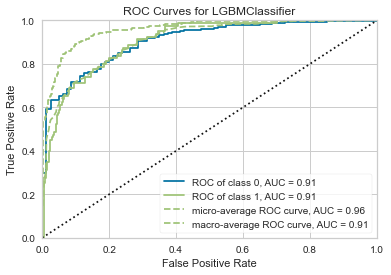

In [13]:
plot_model(lightgbm, plot = 'auc')

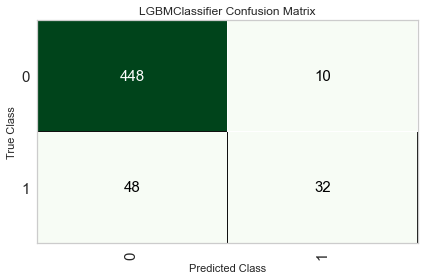

In [14]:
plot_model(lightgbm, plot = 'confusion_matrix')

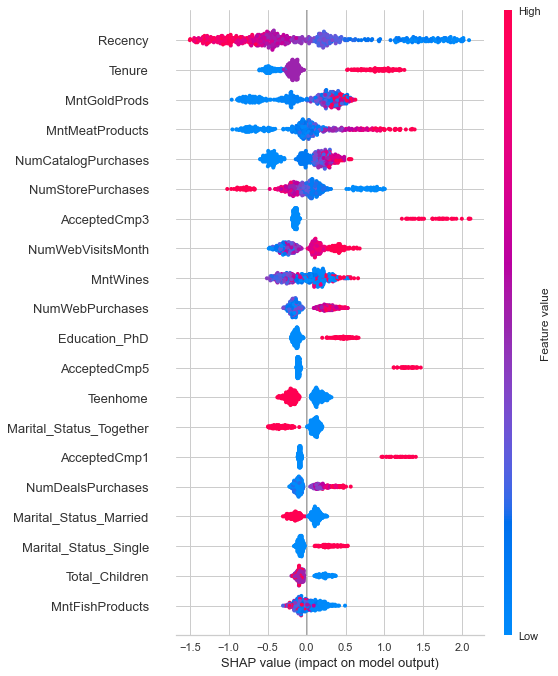

In [15]:
interpret_model(lightgbm)

In [16]:
model = finalize_model(lightgbm)

In [17]:
model

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Income', 'Kidhome', 'Teenhome',
                                             'Recency', 'MntWines', 'MntFruits',
                                             'MntMeatProducts',
                                             'MntFishProducts',
                                             'MntSweetProducts', 'MntGoldProds',
                                             'NumDealsPurchases',
                                             'NumWebPurchases',
                                             'NumCatalogPurchases',
                                             'NumStorePurchases',
                                             'NumWebVisitsMonth',
                                             'AcceptedC...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.5,
                                importance_type='split', learning_rate=0.1,
                                max_depth=-1, min_child_samples=66,
                                min_child_weight=0.001, min_split_gain=0.4,
                                n_estimators=90, n_jobs=-1, num_leaves=90,
                                objective=None, random_state=123,
                                reg_alpha=0.0005, reg_lambda=0.1, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

### Validation

In [18]:
preprocessed_Xtest['predict'] = model.predict(preprocessed_Xtest.drop('Response', axis=1))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(preprocessed_Xtest['Response'], preprocessed_Xtest['predict'])

array([[366,  11],
       [ 44,  25]], dtype=int64)

In [20]:
from sklearn.metrics import recall_score
recall_score(preprocessed_Xtest['Response'], preprocessed_Xtest['predict'], average=None)

array([0.97082228, 0.36231884])

In [21]:
from sklearn.metrics import classification_report
print(classification_report(preprocessed_Xtest['Response'], preprocessed_Xtest['predict']))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       377
           1       0.69      0.36      0.48        69

    accuracy                           0.88       446
   macro avg       0.79      0.67      0.70       446
weighted avg       0.86      0.88      0.86       446

